In [22]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import transformers
transformers.__version__

'4.22.2'

In [46]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
kr_data = pd.read_csv('./drive/MyDrive/newKR.csv')

jp_data = pd.read_csv('./drive/MyDrive/newJPppp.csv')

kr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   39900 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [30]:
kr_data = kr_data.dropna(axis=0)

v2열의 유니크한 값 : 39127
총 샘플의 수 : 39127


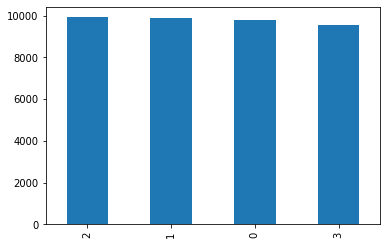

In [31]:
print('v2열의 유니크한 값 :',kr_data['tweet'].nunique())

kr_data.drop_duplicates(subset=['tweet'], inplace=True)

print('총 샘플의 수 :',len(kr_data))

kr_data['label'].value_counts().plot(kind='bar')

In [32]:
x_krdata = kr_data['tweet']
y_krdata = kr_data['label']

print('메일 본문의 개수: {}'.format(len(x_krdata)))
print('레이블의 개수: {}'.format(len(y_krdata)))

X_train, X_test, y_train, y_test = train_test_split(x_krdata, y_krdata, test_size=0.2, random_state=0, stratify=y_krdata)

메일 본문의 개수: 39127
레이블의 개수: 39127


In [33]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [34]:
max_seq_len = 256

In [35]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, data_labels = [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return input_ids, data_labels

In [36]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 31301/31301 [00:19<00:00, 1624.07it/s]


In [37]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 7826/7826 [00:09<00:00, 802.72it/s]


In [38]:
# 최대 길이: 128
input_id = test_X[0]
label = test_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    1  9018 36095 18191  7847  8420 10396 24833 18100  9305     1     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     

In [39]:
model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.8.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'lm_head.weight', 'transformer.h.7.attn.masked_bias', 'transformer.h.0.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [40]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
outputs = model([input_ids_layer])

In [41]:
class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFGPT2ForSequenceClassification, self).__init__()
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.classifier = tf.keras.layers.Dense(4,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        cls_token = outputs[0][:, -1]
        cls_token = self.dropout(cls_token)
        prediction = self.classifier(cls_token)

        return prediction

In [42]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [17]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [43]:
with strategy.scope():
  model = TFGPT2ForSequenceClassification("skt/kogpt2-base-v2")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=2e-4)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

InvalidArgumentError: ignored

In [ ]:
history = model.fit(train_X, train_y, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
392/392 [==============================] - 200s 299ms/step - loss: 0.8486 - accuracy: 0.6712 - val_loss: 0.3359 - val_accuracy: 0.8820
Epoch 2/15
392/392 [==============================] - 59s 150ms/step - loss: 0.2634 - accuracy: 0.9151 - val_loss: 0.2226 - val_accuracy: 0.9257
Epoch 3/15
392/392 [==============================] - 59s 150ms/step - loss: 0.1651 - accuracy: 0.9489 - val_loss: 0.1449 - val_accuracy: 0.9542
Epoch 4/15
392/392 [==============================] - 59s 151ms/step - loss: 0.1134 - accuracy: 0.9650 - val_loss: 0.1395 - val_accuracy: 0.9564
Epoch 5/15
392/392 [==============================] - 59s 151ms/step - loss: 0.0807 - accuracy: 0.9742 - val_loss: 0.1398 - val_accuracy: 0.9570
Epoch 6/15
392/392 [==============================] - 59s 150ms/step - loss: 0.0701 - accuracy: 0.9779 - val_loss: 0.1404 - val_accuracy: 0.9618
Epoch 7/15
392/392 [==============================] - 59s 151ms/step - loss: 0.0479 - accuracy: 0.9846 - val_loss: 0.1528 - val_a

In [ ]:
model.summary()

Model: "tfgpt2_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tfgpt2_model_5 (TFGPT2Model  multiple                 125164032 
 )                                                               
                                                                 
 dropout_226 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 125,167,108
Trainable params: 125,167,108
Non-trainable params: 0
_________________________________________________________________


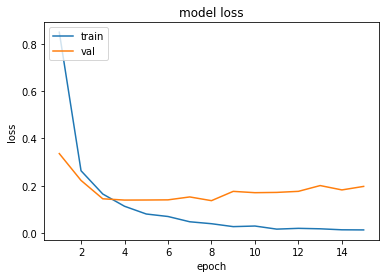

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

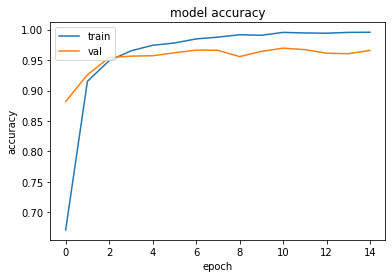

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
results = model.evaluate(test_X, test_y, batch_size=1024)

InternalError: ignored